# K-fold validation of thrombolysis prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

## Load data

In [2]:
data = pd.read_csv('../data/thrombolysis_xgb_data_2017_2019.csv')

In [3]:
data.head()

,stroke team,age,male,infarction,stroke severity,onset-to-arrival time,precise onset known,onset during sleep,use of AF anticoagulants,prior disability,arrival-to-scan time,thrombolysis
0,Peterborough City Hospital,52.5,1,1,2,78,1,0,0,0,87.0,0
1,Royal Hampshire County Hospital,57.5,0,1,7,96,0,1,0,0,58.0,0
2,Basildon University Hospital,67.5,0,1,2,164,1,0,0,0,18.0,0
3,Withybush General Hospital,62.5,1,1,5,150,0,0,0,0,48.0,1
4,Fairfield General Hospital,87.5,0,1,2,65,1,0,0,4,7.0,0


## Split data into X and y

In [4]:
X = data.drop(['thrombolysis'], axis=1)
y = data['thrombolysis']

## Create k-fold splits

Stratify by stroke team and use of thrombolysis.

In [5]:
stratification: pd.Series = (
    data['stroke team'] + data['thrombolysis'].astype(str))

# Create 5 k-fold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(data, stratification.values)

k_fold_train_X = []
k_fold_train_y = []
k_fold_test_X = []
k_fold_test_y = []
k_fold_train_index = []
k_fold_test_index = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    k_fold_train_X.append(X_train)
    k_fold_train_y.append(y_train)
    k_fold_test_X.append(X_test)
    k_fold_test_y.append(y_test)

In [6]:
# Validate using 5-fold cross-validation
accuracies = []
roc_aucs = []
probabilities = []
fpr_kfold = []
tpr_kfold = []
thresholds_kfold = []

for k in range(5):
    # One hot encode hospitals
    X_train_hosp = (pd.get_dummies(
        k_fold_train_X[k]['stroke team'], prefix='team'))
    X_train = pd.concat([k_fold_train_X[k], X_train_hosp], axis=1)
    X_train.drop('stroke team', axis=1, inplace=True)
    X_test_hosp = \
        pd.get_dummies(
            k_fold_test_X[k]['stroke team'], prefix='team')
    X_test = pd.concat([k_fold_test_X[k], X_test_hosp], axis=1)
    X_test.drop('stroke team', axis=1, inplace=True)

    # Create XGBoost model
    model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
    model.fit(X_train, k_fold_train_y[k])

    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    probabilities.append(y_pred_proba)
    accuracy = np.mean(y_pred == k_fold_test_y[k])
    accuracies.append(accuracy)
    print(f'\nAccuracy: {accuracy:.3f}')

    # Get ROC curve
    fpr, tpr, thresholds = \
        roc_curve(k_fold_test_y[k], y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    fpr_kfold.append(fpr)
    tpr_kfold.append(tpr)
    thresholds_kfold.append(thresholds)
    print(f'ROC AUC: {roc_auc:.3f}')

print (f'\nMean accuracy: {np.mean(accuracies):.3f}')
print (f'Mean ROC AUC: {np.mean(roc_aucs):.3f}')


Accuracy: 0.850
ROC AUC: 0.916

Accuracy: 0.851
ROC AUC: 0.918

Accuracy: 0.852
ROC AUC: 0.920

Accuracy: 0.851
ROC AUC: 0.917

Accuracy: 0.848
ROC AUC: 0.918

Mean accuracy: 0.850
Mean ROC AUC: 0.918


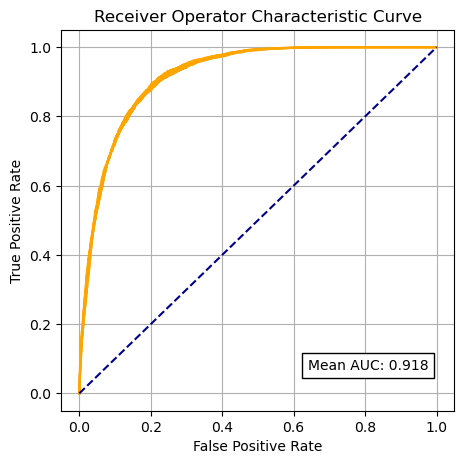

In [8]:
fig = plt.figure(figsize=(5,5))

# Plot ROC
ax1 = fig.add_subplot(111)
for k in range(5):
    ax1.plot(fpr_kfold[k], tpr_kfold[k], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {np.mean(roc_aucs):.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

plt.tight_layout(pad=2)

plt.show()